In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams["savefig.dpi"] = 96
rcParams["figure.dpi"] = 96

# Quickstart

## Running your first inversion

In [2]:
import os

import numpy as np
from bisip import PeltonColeCole
from bisip import DataFiles

# This will get one of the example data files in the BISIP package
data_files = DataFiles()
filepath = data_files['SIP-K389172']

model = PeltonColeCole(filepath=filepath,
                       nwalkers=32,  # number of MCMC walkers
                       nsteps=2000,  # number of MCMC steps
                       headers=9,  # number of lines to skip in the data file
                       )

# Fit the model to this data file
model.fit()

100%|██████████| 2000/2000 [00:02<00:00, 669.38it/s]


## Visualizing the parameter traces

Visual inspection of the traces of each MCMC walker is a good way to quickly assess how well the inversion went. They also define what we consider samples of the posterior distribution. The walkers are initialized at random positions in the parameter space, let's inspect the parameter traces to see if they have moved towards a unique solution to the inverse problem. Plotting the traces is one of the first things the user should do after completing the `fit()` method. Simply call the `plot_traces()` method of the `Inversion` object to visualize the parameter chains.

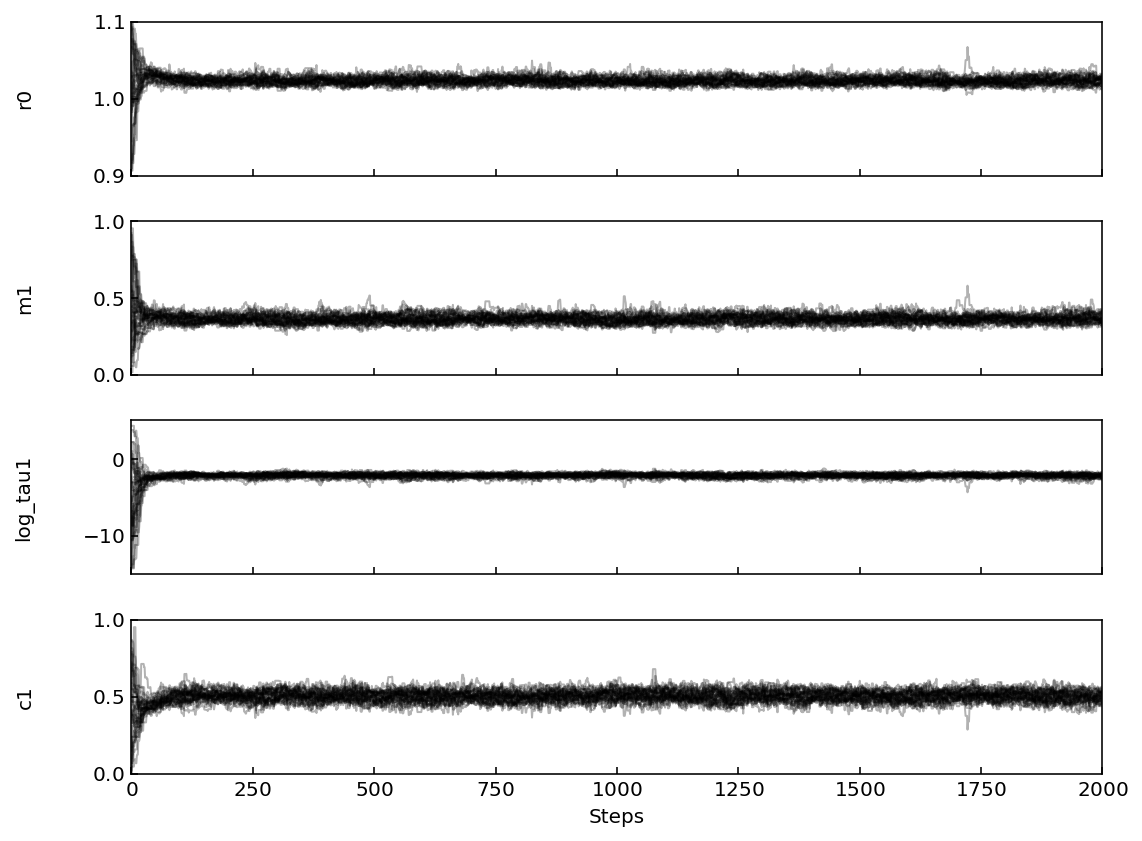

In [3]:
# Plot the parameter traces
fig = model.plot_traces()

The walkers have correctly moved to similar solutions. As you can see for the first few iterations the walkers are spread out across the entire parameter space. The ensemble has then reached a stationary state after at least 50 steps. To be safe, let's discard all the values before the 500th step and use the following steps to estimate the best values for our parameters.

You can also store the chain as a numpy ndarray using the `get_chain()` method. Passing the argument `flat=True` will flatten the walkers into a single chain, whereas passing `flat=False` will preserve the `nwalkers` dimension. The `thin` argument will pick one sample every `thin` steps, this can be used to reduce autocorrelation.

In [4]:
# Get chains of all walkers, discarding first 500 steps
chain = model.get_chain(discard=500)
print(chain.shape)  # (nsteps, nwalkers, ndim)

(1500, 32, 4)


In [5]:
# Get chains of all walkers, discarding first 500 steps,
# thinning by a factor of 2 and flattening the walkers
chain = model.get_chain(discard=500, thin=2, flat=True)
print(chain.shape)  # (nsteps*nwalkers/thin, ndim)

(24000, 4)


## Plotting models over data

Let's now plot the best model obtained with this chain using the `plot_fit()` method, which will show the real and imaginary parts of the complex resistivity as a function of measurement frequency. The plot will also display the median model as a red line and the 95% highest probability density interval as dotted lines.

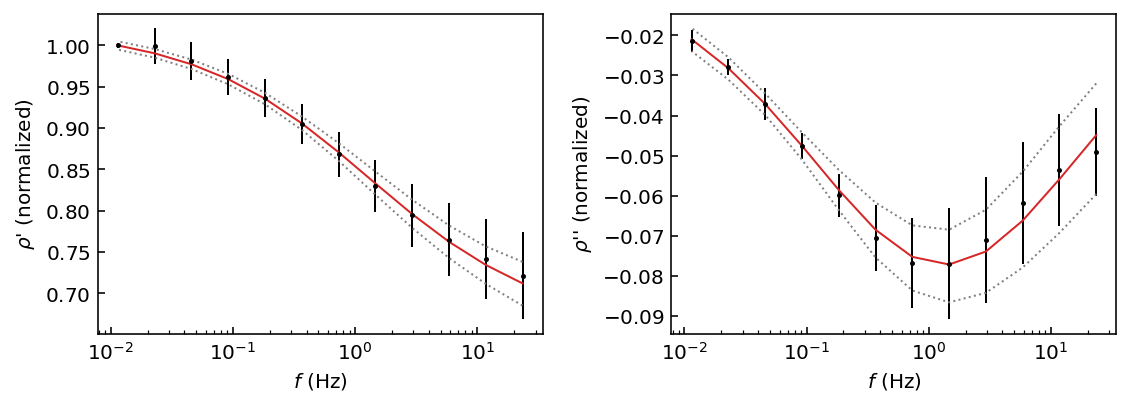

In [6]:
# Use the chain argument to plot the model 
# for a specific flattened chain
fig = model.plot_fit(chain)

# You can then use the `fig` matplotlib object to save the figure or make 
# adjustments according to your personal preference. For example:
# fig.savefig('fit_figure_sample_K389172.png', dpi=144, bbox_inches='tight')

You may also directly pass the arguments of the `get_chain()` method to most plotting functions. By default this will flatten the walkers into a single chain. For example here we use the `plot_fit_pa()` method, which will display the amplitude and phase shift as a function of measurement frequency. We also adjust the confidence interval to display the 72% HPD with the `p` argument (p for percentile). 

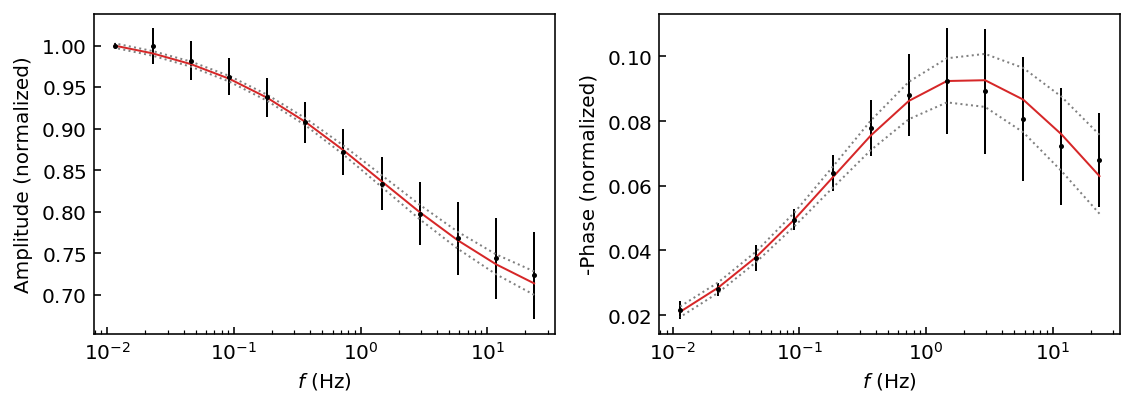

In [7]:
# Use the discard argument to discard samples
# note that we do not need to pass the chain argument
fig = model.plot_fit_pa(discard=500, p=[14, 50, 86])  # 14=lower, 50=median, 86=higher

## Printing best parameters

Here we will use the `get_param_mean()` and `get_param_std()` utility functions to extract the mean and standard deviations of each parameter in our chain. We will also access the name of each parameter with the `param_names` property.

In [8]:
values = model.get_param_mean(chain=chain)
uncertainties = model.get_param_std(chain=chain)

for n, v, u in zip(model.param_names, values, uncertainties):
  print(f'{n}: {v:.5f} +/- {u:.5f}')

r0: 1.02333 +/- 0.00487
m1: 0.36406 +/- 0.02713
log_tau1: -2.14833 +/- 0.26054
c1: 0.50487 +/- 0.03482


Looks good! The relative error on the recovered parameters is quite small considering our large error bars on the data.

## Inspecting the posterior

Let's now visualize the posterior distribution of all parameters using a
corner plot (from the corner Python package).

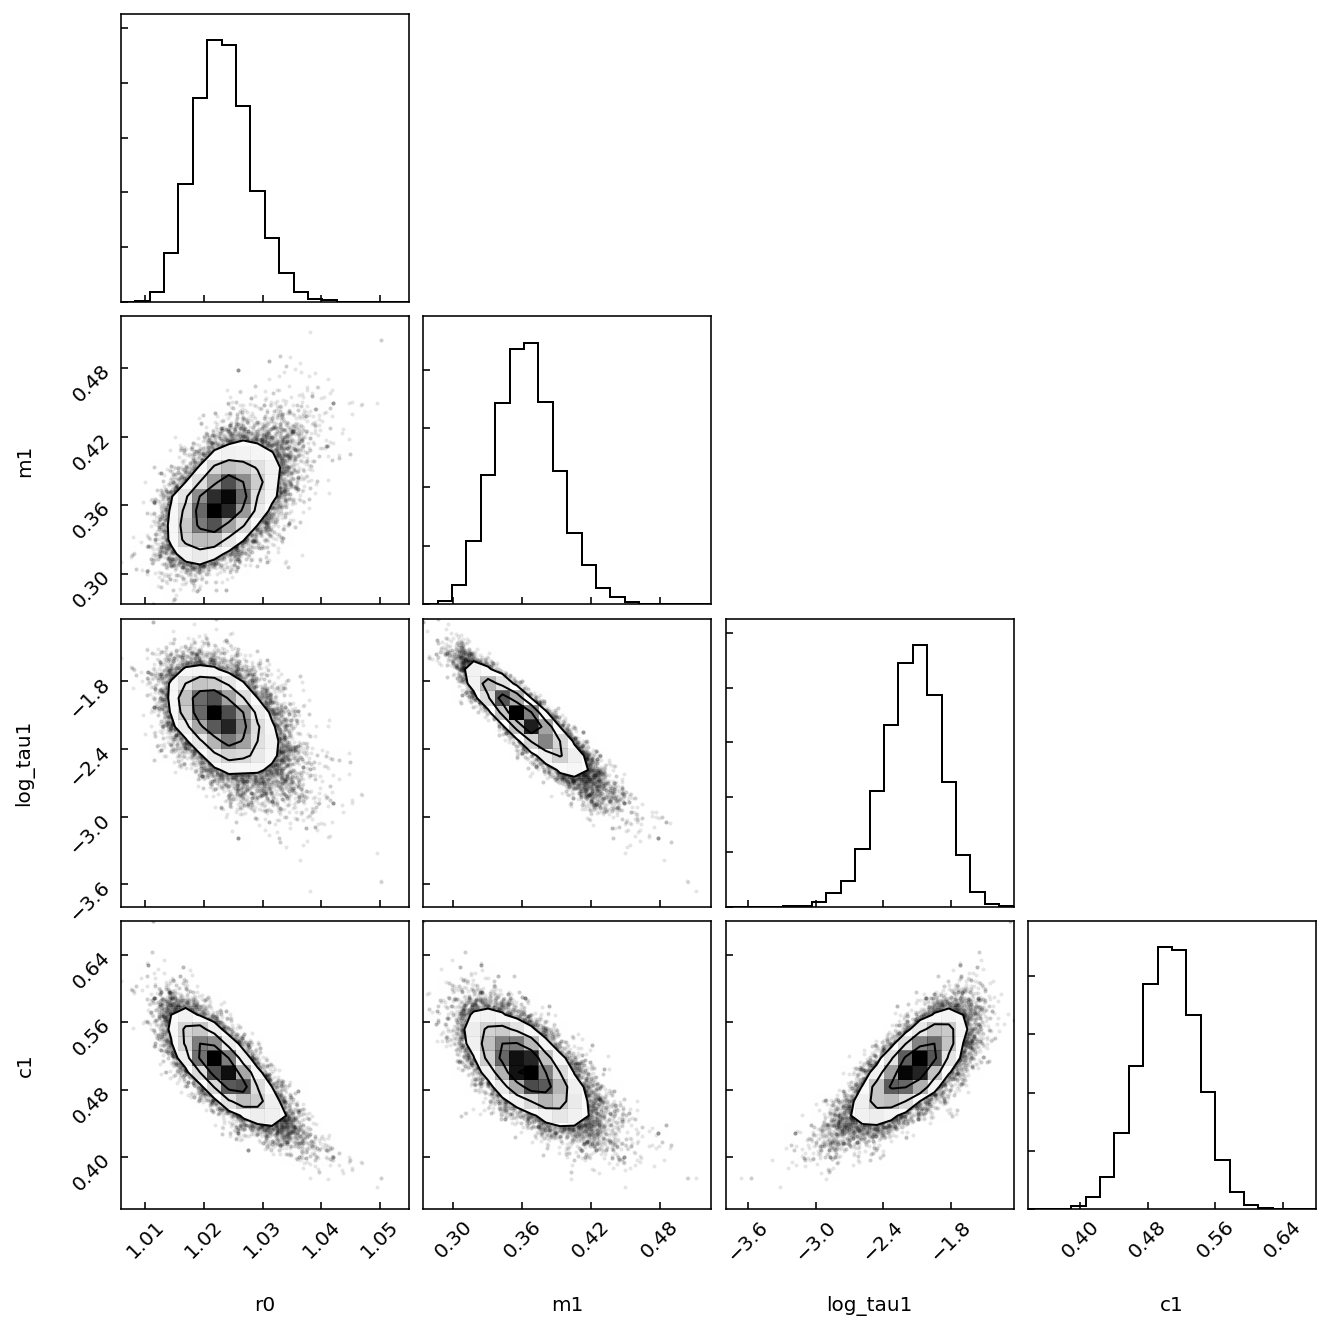

In [9]:
fig = model.plot_corner(chain=chain)

This is interesting, we note that the $\log \tau$ values are anticorrelated with the $m$ values. It seems like the model can obtain similar fits of the data by adjusting these parameters against each other.

## Saving results to CSV file

Finally let's save the best parameters and some of their statistics as a csv file.

In [10]:
# Get the lower, median and higher percentiles
results = model.get_param_percentile(chain=chain, p=[2.5, 50, 97.5])
# Join the list of parameter names into a comma separated string
headers = ','.join(model.param_names)
# Save to csv with numpy
# The first row is the 2.5th percentile, 2nd the 50th (median), 3rd the 97.5th.
# Parameter names will be listed in the csv file header.

In [11]:
print(headers)

r0,m1,log_tau1,c1


In [12]:
print(results)

[[ 1.01453349  0.31500568 -2.70329727  0.43543147]
 [ 1.02309316  0.36300182 -2.13243101  0.50552808]
 [ 1.03359589  0.42079635 -1.68217846  0.57123444]]


In [13]:
np.savetxt('quickstart_results.csv', results, header=headers,
           delimiter=',', comments='')